## Experiment: Resnet-18 (Learning rate)
### Resnet-18 (baseline) 
- Learning rate = 0.1
- optimizers = SGD
- with residual links (out += self.shortcut(x))

In [ ]:
# 
# pip install seaborn

In [ ]:
# Just checking b4 start
import torch

if torch.cuda.is_available():
    print(f"CUDA is available! Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available, using CPU.")


CUDA is available! Using GPU: Quadro RTX 4000


In [31]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, Subset, DataLoader, random_split
import torchvision
from torchvision import transforms, models, utils

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tqdm import tqdm

import tensorflow as tf

import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim


import seaborn as sns

In [5]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes) 
        
        self.conv2 = nn.Conv2d(planes,planes,kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Identity() 
        if stride != 1:            
            self.shortcut = nn.Sequential(
                            nn.Conv2d(in_planes, planes, kernel_size = 1, stride = stride, bias = False),
                            nn.BatchNorm2d(planes)
                            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  
        out = F.relu(out)
        
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3,64,kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride = 1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride = 2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride = 2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride = 2)
        self.linear = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1) 
        out = self.linear(out)
        
        return out

In [29]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding = 4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root= './data', train = True, download = True, transform = train_transform)
test_dataset = torchvision.datasets.CIFAR10(root= './data', train = False, download = True, transform = test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [30]:
# Have a look into 
print("Training dataset size: ", len(train_dataset))
print("Testing dataset size: ", len(test_dataset))


Training dataset size:  50000
Testing dataset size:  10000


In [27]:
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

In [33]:
# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

def train_epoch(model, train_loader, device, optimizer, loss_function):
    model.train() # set model to training mode

    #### For calculation only:
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        #### For calculation only:
        running_train_loss += loss.item() # need this for training too
        correct_train += calculate_accuracy(outputs, labels) * labels.size(0)
        total_train += labels.size(0)

    # Calculate training loss and accuracy for the epoch
    avg_train_loss = running_train_loss / len(train_loader)
    avg_train_acc = correct_train / total_train
    return avg_train_loss, avg_train_acc


def val_epoch(model, val_loader, device, loss_function):
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            #### For calculation only:
            running_val_loss += loss.item()
            correct_val += calculate_accuracy(outputs, labels) * labels.size(0)
            total_val += labels.size(0)

    # Calculate validation loss and accuracy for the epoch
    avg_val_loss = running_val_loss / len(val_loader)
    avg_val_acc = correct_val / total_val
    return avg_val_loss, avg_val_acc

In [34]:
from sklearn.model_selection import KFold

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cudnn.benchmark = True

# Example using KFold cross-validation
K_FOLDS = 5
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

val_loss_history_cv = []
learning_rates = [0.001, 0.01, 0.1]

## overall metrics
val_loss_history = []
train_loss_history = []
train_acc_history = []
val_acc_history = []

# Loop through different learning rates
for lr in learning_rates:

    # Track metrics for this learning rate (for all k-fold)
    fold_train_loss_history = []
    fold_train_acc_history = []
    fold_val_loss_history = []
    fold_val_acc_history = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
        print(f"Fold {fold+1}/{K_FOLDS}")

        # Create training and validation datasets based on the indices
        train_subset = Subset(train_dataset, train_idx)
        val_subset = Subset(train_dataset, val_idx)
        
        train_loader = DataLoader(train_subset, batch_size = 128, shuffle = True, num_workers = 4, pin_memory=True)
        val_loader  = DataLoader(val_subset, batch_size = 100, shuffle = False, num_workers = 4, pin_memory=True)

        # Train the model on the current fold
        model = ResNet18()
        model = model.to(device)
        # model = torch.nn.DataParallel(model) # parallelize a model across multiple GPUs(if got)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.9, weight_decay = 0.0002)
        # Loss function 
        loss_function = nn.CrossEntropyLoss()

        # Track metrics for the current fold
        train_loss_per_epoch = []
        train_acc_per_epoch = []
        val_loss_per_epoch = []
        val_acc_per_epoch = []

        ##################
        # Training ......
        num_epochs = 20
        for epoch in range(num_epochs):
            ##################
            # Training on the training fold
            avg_train_loss, avg_train_acc = train_epoch(model, train_loader, device, optimizer, loss_function)
            train_loss_per_epoch.append(avg_train_loss)
            train_acc_per_epoch.append(avg_train_acc)

            ##################
            # Evaluate on the validation fold
            avg_val_loss, avg_val_acc = val_epoch(model, val_loader, device, loss_function)
            val_loss_per_epoch.append(avg_val_loss)
            val_acc_per_epoch.append(avg_val_acc)

            # Print stats for the current epoch
            print(f"Epoch {epoch+1}/{num_epochs} - "
                f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc*100:.2f}%, "
                f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_acc*100:.2f}%")
    
        # Store this fold only - calculate average loss and accuracy
        fold_train_loss_history.append(np.mean(train_loss_per_epoch))
        fold_train_acc_history.append(np.mean(train_acc_per_epoch))
        fold_val_loss_history.append(np.mean(val_loss_per_epoch))
        fold_val_acc_history.append(np.mean(val_acc_per_epoch))


    # Calculate the average metrics for the current learning rate (across all folds)
    avg_train_loss = np.mean(fold_train_loss_history)
    avg_train_acc = np.mean(fold_train_acc_history)
    avg_val_loss = np.mean(fold_val_loss_history)
    avg_val_acc = np.mean(fold_val_acc_history)

    # Append the results for this learning rate
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)
    train_acc_history.append(avg_train_acc)
    val_acc_history.append(avg_val_acc)

Fold 1/5
Epoch 1/20 - Train Loss: 1.6776, Train Accuracy: 37.95%, Val Loss: 1.4759, Val Accuracy: 45.41%
Epoch 2/20 - Train Loss: 1.2898, Train Accuracy: 53.04%, Val Loss: 1.2650, Val Accuracy: 54.11%
Epoch 3/20 - Train Loss: 1.0997, Train Accuracy: 60.33%, Val Loss: 1.3320, Val Accuracy: 53.65%
Epoch 4/20 - Train Loss: 0.9660, Train Accuracy: 65.58%, Val Loss: 1.1421, Val Accuracy: 59.44%
Epoch 5/20 - Train Loss: 0.8616, Train Accuracy: 69.26%, Val Loss: 1.0043, Val Accuracy: 63.55%
Epoch 6/20 - Train Loss: 0.7888, Train Accuracy: 71.98%, Val Loss: 1.0418, Val Accuracy: 63.47%
Epoch 7/20 - Train Loss: 0.7112, Train Accuracy: 74.98%, Val Loss: 0.7682, Val Accuracy: 72.94%
Epoch 8/20 - Train Loss: 0.6531, Train Accuracy: 77.03%, Val Loss: 0.7079, Val Accuracy: 75.75%
Epoch 9/20 - Train Loss: 0.6036, Train Accuracy: 79.02%, Val Loss: 0.8072, Val Accuracy: 71.88%
Epoch 10/20 - Train Loss: 0.5568, Train Accuracy: 80.56%, Val Loss: 0.9105, Val Accuracy: 70.73%
Epoch 11/20 - Train Loss: 0.52

In [ ]:
import pandas as pd

# Create a DataFrame to store all the metrics
df = pd.DataFrame({
    'train_loss': train_loss_history,
    'val_loss': val_loss_history,
    'train_accuracy': train_acc_history,
    'val_accuracy': val_acc_history
})

# Save to CSV
df.to_csv('learning_rate_metrics.csv', index=False)


###### Testing only
# Load the data from the CSV file
df = pd.read_csv('learning_rate_metrics.csv')

# Access the columns as arrays
print(df['train_loss'].values)
print(df['val_loss'].values)
print(df['train_accuracy'].values)
print(df['val_accuracy'].values)


[0.65331837 0.46408036 0.71898667]
[0.80664731 0.62868081 0.88141027]
[0.767826   0.83627875 0.7451225 ]
[0.721553 0.791539 0.698514]


In [ ]:
################3
## This is just for saving the results for each learning rate
import re
import pandas as pd
import numpy as np
# Define a function to parse the log file and calculate the averages
def parse_log_file(log_file):
    # Initialize lists to store data for each fold
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Read the file content
    with open(log_file, 'r') as f:
        lines = f.readlines()

    # Initialize temporary lists to hold the values for each fold
    temp_train_loss = []
    temp_train_accuracy = []
    temp_val_loss = []
    temp_val_accuracy = []

    # Regular expression pattern to capture the necessary log values
    epoch_pattern = re.compile(
        r"Epoch (\d+)/\d+ - Train Loss: ([\d.]+), Train Accuracy: ([\d.]+)%, "
        r"Val Loss: ([\d.]+), Val Accuracy: ([\d.]+)%"
    )

    # Loop over the lines and extract the data
    for line in lines:
        # If a line matches the epoch pattern, extract the values
        match = epoch_pattern.match(line)
        if match:
            epoch = int(match.group(1))
            train_loss = float(match.group(2))
            train_accuracy = float(match.group(3))
            val_loss = float(match.group(4))
            val_accuracy = float(match.group(5))

            # Append the values to the temporary lists for this fold
            temp_train_loss.append(train_loss)
            temp_train_accuracy.append(train_accuracy)
            temp_val_loss.append(val_loss)
            temp_val_accuracy.append(val_accuracy)

        # If a new fold is encountered (i.e., "Fold x/y"), save the results for the previous fold
        elif line.startswith("Fold"):
            # If we already have values from a previous fold, save them
            if temp_train_loss:
                train_losses.append(temp_train_loss)
                train_accuracies.append(temp_train_accuracy)
                val_losses.append(temp_val_loss)
                val_accuracies.append(temp_val_accuracy)

            # Reset temporary lists for the next fold
            temp_train_loss = []
            temp_train_accuracy = []
            temp_val_loss = []
            temp_val_accuracy = []

    # Append the last fold's results
    if temp_train_loss:
        train_losses.append(temp_train_loss)
        train_accuracies.append(temp_train_accuracy)
        val_losses.append(temp_val_loss)
        val_accuracies.append(temp_val_accuracy)

    # Convert lists to numpy arrays for easier manipulation
    train_losses = np.array(train_losses)
    train_accuracies = np.array(train_accuracies)
    val_losses = np.array(val_losses)
    val_accuracies = np.array(val_accuracies)

    return train_losses, train_accuracies, val_losses, val_accuracies

# Function to calculate average for each epoch across all folds
def calculate_averages(train_losses, train_accuracies, val_losses, val_accuracies):
    avg_train_losses = np.mean(train_losses, axis=0)
    avg_train_accuracies = np.mean(train_accuracies, axis=0)
    avg_val_losses = np.mean(val_losses, axis=0)
    avg_val_accuracies = np.mean(val_accuracies, axis=0)

    return avg_train_losses, avg_train_accuracies, avg_val_losses, avg_val_accuracies

# Function to save the results to a CSV file
def save_results_to_csv(avg_train_losses, avg_train_accuracies, avg_val_losses, avg_val_accuracies):
    # Create a DataFrame to store the results
    df = pd.DataFrame({
        'Epoch': np.arange(1, len(avg_train_losses) + 1),
        'Avg Train Loss': avg_train_losses,
        'Avg Train Accuracy': avg_train_accuracies,
        'Avg Val Loss': avg_val_losses,
        'Avg Val Accuracy': avg_val_accuracies
    })

    return df


log_file = 'learning_rate_results/learning_rate0001.txt'  #

train_losses, train_accuracies, val_losses, val_accuracies = parse_log_file(log_file)

# Calculate the averages for each epoch
avg_train_losses, avg_train_accuracies, avg_val_losses, avg_val_accuracies = calculate_averages(
    train_losses, train_accuracies, val_losses, val_accuracies
)

# Save the averaged results to a CSV file
df = save_results_to_csv(avg_train_losses, avg_train_accuracies, avg_val_losses, avg_val_accuracies)
print(df)
df.to_csv('training_results_learning_rate0001.csv', index=False)

    Epoch  Avg Train Loss  Avg Train Accuracy  Avg Val Loss  Avg Val Accuracy
0       1         1.67506              37.798       1.47634            45.772
1       2         1.28860              53.164       1.24454            55.584
2       3         1.08434              61.048       1.20430            57.326
3       4         0.94452              66.222       1.12822            60.552
4       5         0.83788              70.276       0.98098            65.660
5       6         0.76026              73.156       0.95560            67.440
6       7         0.68978              75.816       0.78496            72.466
7       8         0.63344              77.804       0.92994            69.444
8       9         0.58326              79.662       0.74324            74.328
9      10         0.54408              80.946       0.72912            75.414
10     11         0.51016              82.258       0.66466            77.234
11     12         0.48132              83.174       0.69780     

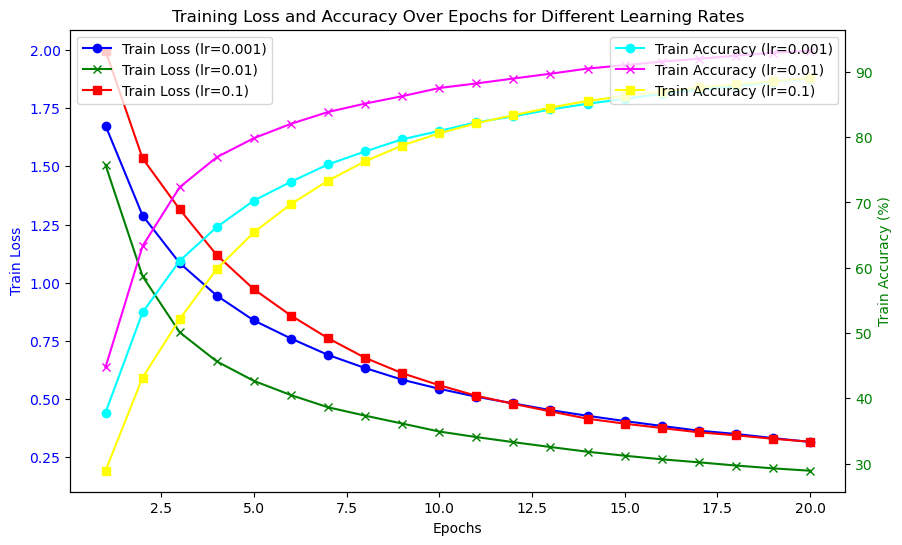

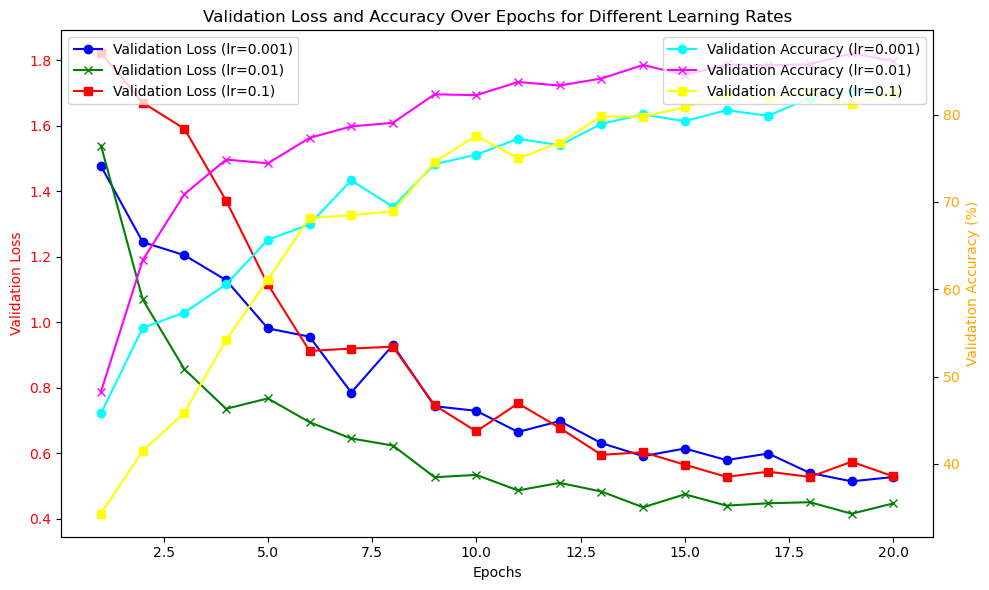

In [25]:

df1 = pd.read_csv('learning_rate_results/training_results_learning_rate0001.csv')
df2 = pd.read_csv('learning_rate_results/training_results_learning_rate001.csv')
df3 = pd.read_csv('learning_rate_results/training_results_learning_rate01.csv')


epochs1 = df1['Epoch']
train_loss1 = df1['Avg Train Loss']
train_accuracy1 = df1['Avg Train Accuracy']
val_loss1 = df1['Avg Val Loss']
val_accuracy1 = df1['Avg Val Accuracy']

epochs2 = df2['Epoch']
train_loss2 = df2['Avg Train Loss']
train_accuracy2 = df2['Avg Train Accuracy']
val_loss2 = df2['Avg Val Loss']
val_accuracy2 = df2['Avg Val Accuracy']

epochs3 = df3['Epoch']
train_loss3 = df3['Avg Train Loss']
train_accuracy3 = df3['Avg Train Accuracy']
val_loss3 = df3['Avg Val Loss']
val_accuracy3 = df3['Avg Val Accuracy']

# Create a figure and axis for the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Training Loss for each learning rate
ax1.plot(epochs1, train_loss1, label='Train Loss (lr=0.001)', color='blue', linestyle='-', marker='o')
ax1.plot(epochs2, train_loss2, label='Train Loss (lr=0.01)', color='green', linestyle='-', marker='x')
ax1.plot(epochs3, train_loss3, label='Train Loss (lr=0.1)', color='red', linestyle='-', marker='s')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Train Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Training Loss and Accuracy Over Epochs for Different Learning Rates')

# Create a second y-axis for Training Accuracy
ax2 = ax1.twinx()
ax2.plot(epochs1, train_accuracy1, label='Train Accuracy (lr=0.001)', color='cyan', linestyle='-', marker='o')
ax2.plot(epochs2, train_accuracy2, label='Train Accuracy (lr=0.01)', color='magenta', linestyle='-', marker='x')
ax2.plot(epochs3, train_accuracy3, label='Train Accuracy (lr=0.1)', color='yellow', linestyle='-', marker='s')
ax2.set_ylabel('Train Accuracy (%)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Plot Validation Loss and Accuracy with a new set of axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Validation Loss for each learning rate
ax1.plot(epochs1, val_loss1, label='Validation Loss (lr=0.001)', color='blue', linestyle='-', marker='o')
ax1.plot(epochs2, val_loss2, label='Validation Loss (lr=0.01)', color='green', linestyle='-', marker='x')
ax1.plot(epochs3, val_loss3, label='Validation Loss (lr=0.1)', color='red', linestyle='-', marker='s')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Loss', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_title('Validation Loss and Accuracy Over Epochs for Different Learning Rates')

# Create a second y-axis for Validation Accuracy
ax2 = ax1.twinx()
ax2.plot(epochs1, val_accuracy1, label='Validation Accuracy (lr=0.001)', color='cyan', linestyle='-', marker='o')
ax2.plot(epochs2, val_accuracy2, label='Validation Accuracy (lr=0.01)', color='magenta', linestyle='-', marker='x')
ax2.plot(epochs3, val_accuracy3, label='Validation Accuracy (lr=0.1)', color='yellow', linestyle='-', marker='s')
ax2.set_ylabel('Validation Accuracy (%)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plots
plt.tight_layout()
plt.show()


## Experiment: Resnet-18 (with or without residual links)


### 1. ResNet-18 without residual links

In [38]:
class BasicBlockNoResidual(nn.Module):
    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlockNoResidual, self).__init__()
        
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes) 
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Identity()  # This is kept for consistency but won't be used

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        # No shortcut addition, just return the transformed output
        out = F.relu(out)
        return out
    
def ResNet18_Woutresidual():
    return ResNet(BasicBlockNoResidual, [2,2,2,2])


In [39]:
from sklearn.model_selection import KFold

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cudnn.benchmark = True

# Example using KFold cross-validation
K_FOLDS = 5
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

lr = 0.1

# Function to save model checkpoint
def save_checkpoint(model, optimizer, epoch, loss, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filename)  # Save the checkpoint


# History for all K-Folds = (overall metrics)
fold_train_loss_history = []
fold_train_acc_history = []
fold_val_loss_history = []
fold_val_acc_history = []
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f"Fold {fold+1}/{K_FOLDS}")

    # Create training and validation datasets based on the indices
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)
    
    train_loader = DataLoader(train_subset, batch_size = 128, shuffle = True, num_workers = 4, pin_memory=True)
    val_loader  = DataLoader(val_subset, batch_size = 100, shuffle = False, num_workers = 4, pin_memory=True)

    # Train the model on the current fold
    model = ResNet18_Woutresidual()
    model = model.to(device)
    # model = torch.nn.DataParallel(model) # parallelize a model across multiple GPUs(if got)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.9, weight_decay = 0.0002)
    # Loss function 
    loss_function = nn.CrossEntropyLoss()

    # Track metrics for the current fold
    train_loss_per_epoch = []
    train_acc_per_epoch = []
    val_loss_per_epoch = []
    val_acc_per_epoch = []

    ##################
    # Training ......
    num_epochs = 20
    for epoch in range(num_epochs):
        ##################
        # Training on the training fold
        avg_train_loss, avg_train_acc = train_epoch(model, train_loader, device, optimizer, loss_function)
        train_loss_per_epoch.append(avg_train_loss)
        train_acc_per_epoch.append(avg_train_acc)

        ##################
        # Evaluate on the validation fold
        avg_val_loss, avg_val_acc = val_epoch(model, val_loader, device, loss_function)
        val_loss_per_epoch.append(avg_val_loss)
        val_acc_per_epoch.append(avg_val_acc)

        # Print stats for the current epoch
        print(f"Epoch {epoch+1}/{num_epochs} - "
            f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc*100:.2f}%, "
            f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_acc*100:.2f}%")

    # After each folds, save the checkpoint
    save_checkpoint(model, optimizer, epoch, np.mean(train_loss_per_epoch), f'without_residual_checkpoint/checkpoint_fold_{fold+1}.pth')
    # Store this fold only - calculate average loss and accuracy
    fold_train_loss_history.append(np.mean(train_loss_per_epoch))
    fold_train_acc_history.append(np.mean(train_acc_per_epoch))
    fold_val_loss_history.append(np.mean(val_loss_per_epoch))
    fold_val_acc_history.append(np.mean(val_acc_per_epoch))


 

Fold 1/5
Epoch 1/20 - Train Loss: 1.8808, Train Accuracy: 28.20%, Val Loss: 2.0367, Val Accuracy: 29.96%
Epoch 2/20 - Train Loss: 1.5567, Train Accuracy: 42.11%, Val Loss: 1.6543, Val Accuracy: 41.31%
Epoch 3/20 - Train Loss: 1.3203, Train Accuracy: 51.82%, Val Loss: 1.4373, Val Accuracy: 49.81%
Epoch 4/20 - Train Loss: 1.1565, Train Accuracy: 57.94%, Val Loss: 1.5436, Val Accuracy: 50.40%
Epoch 5/20 - Train Loss: 1.0415, Train Accuracy: 62.79%, Val Loss: 1.2091, Val Accuracy: 56.32%
Epoch 6/20 - Train Loss: 0.9470, Train Accuracy: 66.42%, Val Loss: 0.9362, Val Accuracy: 66.73%
Epoch 7/20 - Train Loss: 0.8540, Train Accuracy: 70.06%, Val Loss: 1.0386, Val Accuracy: 63.81%
Epoch 8/20 - Train Loss: 0.7688, Train Accuracy: 73.17%, Val Loss: 0.8207, Val Accuracy: 71.47%
Epoch 9/20 - Train Loss: 0.6998, Train Accuracy: 75.77%, Val Loss: 0.9636, Val Accuracy: 67.91%
Epoch 10/20 - Train Loss: 0.6424, Train Accuracy: 77.93%, Val Loss: 0.8518, Val Accuracy: 70.72%
Epoch 11/20 - Train Loss: 0.60

In [23]:
log_file = 'residual_links_results/withoutresidual.txt'  #

train_losses, train_accuracies, val_losses, val_accuracies = parse_log_file(log_file)

# Calculate the averages for each epoch
avg_train_losses, avg_train_accuracies, avg_val_losses, avg_val_accuracies = calculate_averages(
    train_losses, train_accuracies, val_losses, val_accuracies
)

# Save the averaged results to a CSV file
df = save_results_to_csv(avg_train_losses, avg_train_accuracies, avg_val_losses, avg_val_accuracies)
print(df)
df.to_csv('residual_links_results/withoutresidual_metrics.csv', index=False)

    Epoch  Avg Train Loss  Avg Train Accuracy  Avg Val Loss  Avg Val Accuracy
0       1         1.87506              29.000       1.93240            31.182
1       2         1.58924              40.514       1.82990            37.708
2       3         1.36652              49.866       1.42102            48.848
3       4         1.18478              56.988       1.32732            53.818
4       5         1.04848              62.462       1.26814            55.670
5       6         0.93990              66.666       1.15256            61.886
6       7         0.84716              70.128       0.99994            65.380
7       8         0.76696              73.288       0.91676            68.198
8       9         0.70170              75.660       0.88250            70.114
9      10         0.64602              77.754       0.81248            72.262
10     11         0.59878              79.278       0.81752            72.216
11     12         0.56292              80.680       0.73968     

### 2. ResNet-18 with residual links

In [41]:

# History for all K-Folds = (overall metrics)
fold_train_loss_history1 = []
fold_train_acc_history1 = []
fold_val_loss_history1 = []
fold_val_acc_history1 = []
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f"Fold {fold+1}/{K_FOLDS}")

    # Create training and validation datasets based on the indices
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)
    
    train_loader = DataLoader(train_subset, batch_size = 128, shuffle = True, num_workers = 4, pin_memory=True)
    val_loader  = DataLoader(val_subset, batch_size = 100, shuffle = False, num_workers = 4, pin_memory=True)

    # Train the model on the current fold
    model = ResNet18()
    model = model.to(device)
    # model = torch.nn.DataParallel(model) # parallelize a model across multiple GPUs(if got)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.9, weight_decay = 0.0002)
    # Loss function 
    loss_function = nn.CrossEntropyLoss()

    # Track metrics for the current fold
    train_loss_per_epoch = []
    train_acc_per_epoch = []
    val_loss_per_epoch = []
    val_acc_per_epoch = []

    ##################
    # Training ......
    num_epochs = 20
    for epoch in range(num_epochs):
        ##################
        # Training on the training fold
        avg_train_loss, avg_train_acc = train_epoch(model, train_loader, device, optimizer, loss_function)
        train_loss_per_epoch.append(avg_train_loss)
        train_acc_per_epoch.append(avg_train_acc)

        ##################
        # Evaluate on the validation fold
        avg_val_loss, avg_val_acc = val_epoch(model, val_loader, device, loss_function)
        val_loss_per_epoch.append(avg_val_loss)
        val_acc_per_epoch.append(avg_val_acc)

        # Print stats for the current epoch
        print(f"Epoch {epoch+1}/{num_epochs} - "
            f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc*100:.2f}%, "
            f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_acc*100:.2f}%")

    # After each folds, save the checkpoint
    save_checkpoint(model, optimizer, epoch, np.mean(train_loss_per_epoch), f'residual_checkpoint/checkpoint_fold_{fold+1}.pth')
    # Store this fold only - calculate average loss and accuracy
    fold_train_loss_history1.append(np.mean(train_loss_per_epoch))
    fold_train_acc_history1.append(np.mean(train_acc_per_epoch))
    fold_val_loss_history1.append(np.mean(val_loss_per_epoch))
    fold_val_acc_history1.append(np.mean(val_acc_per_epoch))


 

Fold 1/5
Epoch 1/20 - Train Loss: 2.1612, Train Accuracy: 23.39%, Val Loss: 2.4292, Val Accuracy: 22.90%
Epoch 2/20 - Train Loss: 1.5964, Train Accuracy: 40.27%, Val Loss: 1.7324, Val Accuracy: 38.82%
Epoch 3/20 - Train Loss: 1.3855, Train Accuracy: 48.92%, Val Loss: 1.9114, Val Accuracy: 37.56%
Epoch 4/20 - Train Loss: 1.1908, Train Accuracy: 57.04%, Val Loss: 1.2025, Val Accuracy: 57.72%
Epoch 5/20 - Train Loss: 1.0368, Train Accuracy: 62.99%, Val Loss: 1.2661, Val Accuracy: 55.31%
Epoch 6/20 - Train Loss: 0.9257, Train Accuracy: 67.02%, Val Loss: 1.1675, Val Accuracy: 58.99%
Epoch 7/20 - Train Loss: 0.8266, Train Accuracy: 70.86%, Val Loss: 0.9973, Val Accuracy: 64.59%
Epoch 8/20 - Train Loss: 0.7606, Train Accuracy: 72.99%, Val Loss: 0.7746, Val Accuracy: 72.38%
Epoch 9/20 - Train Loss: 0.6864, Train Accuracy: 75.89%, Val Loss: 0.8690, Val Accuracy: 70.20%
Epoch 10/20 - Train Loss: 0.6313, Train Accuracy: 77.83%, Val Loss: 0.6973, Val Accuracy: 75.51%
Epoch 11/20 - Train Loss: 0.56

In [24]:
log_file = 'residual_links_results/withresidual.txt'  #

train_losses, train_accuracies, val_losses, val_accuracies = parse_log_file(log_file)

# Calculate the averages for each epoch
avg_train_losses, avg_train_accuracies, avg_val_losses, avg_val_accuracies = calculate_averages(
    train_losses, train_accuracies, val_losses, val_accuracies
)

# Save the averaged results to a CSV file
df = save_results_to_csv(avg_train_losses, avg_train_accuracies, avg_val_losses, avg_val_accuracies)
print(df)
df.to_csv('residual_links_results/withresidual_metrics.csv', index=False)

    Epoch  Avg Train Loss  Avg Train Accuracy  Avg Val Loss  Avg Val Accuracy
0       1         2.03652              27.078       1.90156            32.066
1       2         1.54152              42.574       1.69060            41.238
2       3         1.31760              51.890       1.71260            43.116
3       4         1.12120              59.724       1.32128            53.666
4       5         0.97088              65.476       1.04372            63.044
5       6         0.86182              69.482       1.07402            62.734
6       7         0.76706              73.090       0.98892            66.180
7       8         0.68470              75.954       0.89004            70.518
8       9         0.62286              78.168       0.76566            73.604
9      10         0.57212              80.034       0.69704            76.018
10     11         0.51938              81.946       0.63612            78.364
11     12         0.48248              83.240       0.73190     

### Compare between ResNet-18 with and without residual links 

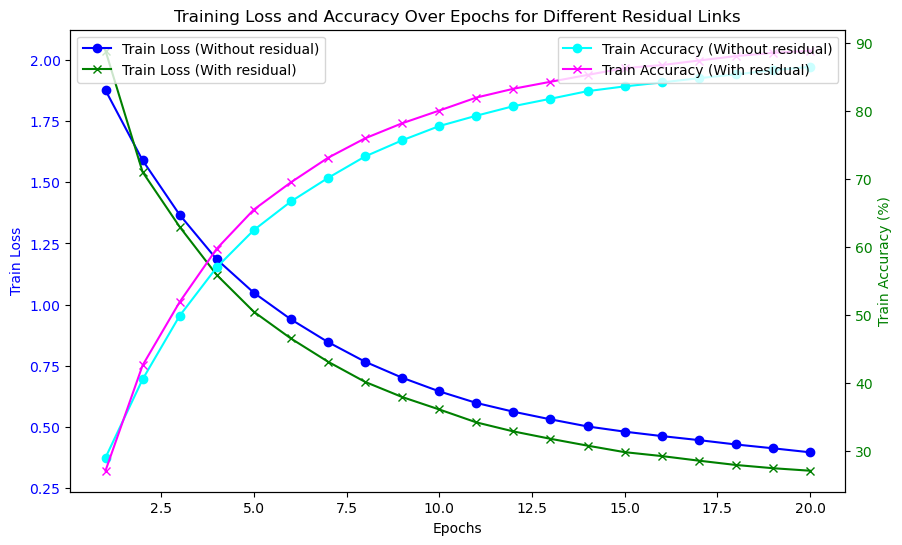

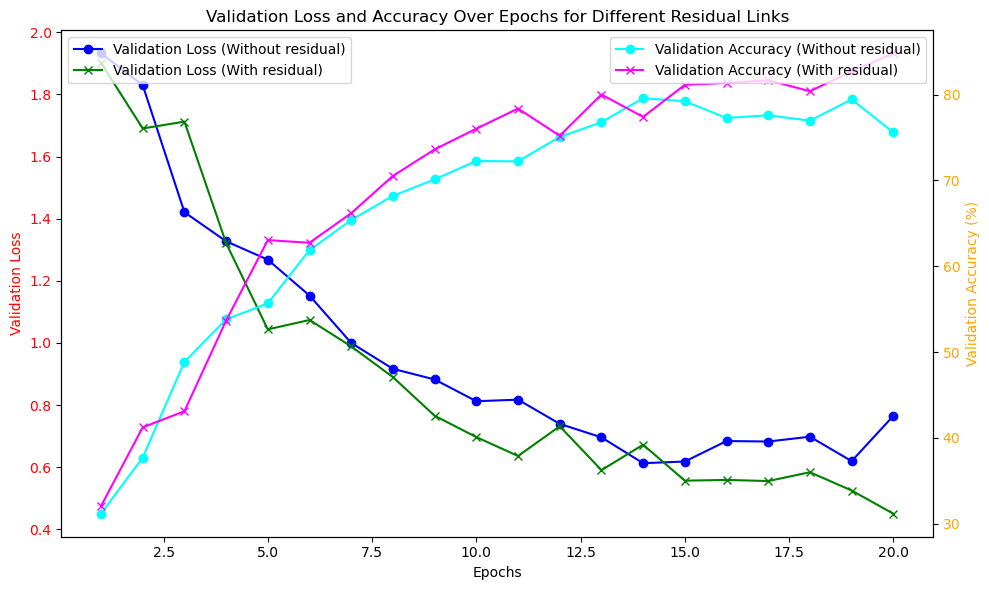

In [26]:
df1 = pd.read_csv('residual_links_results/withoutresidual_metrics.csv')
df2 = pd.read_csv('residual_links_results/withresidual_metrics.csv')


epochs1 = df1['Epoch']
train_loss1 = df1['Avg Train Loss']
train_accuracy1 = df1['Avg Train Accuracy']
val_loss1 = df1['Avg Val Loss']
val_accuracy1 = df1['Avg Val Accuracy']

epochs2 = df2['Epoch']
train_loss2 = df2['Avg Train Loss']
train_accuracy2 = df2['Avg Train Accuracy']
val_loss2 = df2['Avg Val Loss']
val_accuracy2 = df2['Avg Val Accuracy']

# Create a figure and axis for the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Training Loss for each learning rate
ax1.plot(epochs1, train_loss1, label='Train Loss (Without residual)', color='blue', linestyle='-', marker='o')
ax1.plot(epochs2, train_loss2, label='Train Loss (With residual)', color='green', linestyle='-', marker='x')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Train Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Training Loss and Accuracy Over Epochs for Different Residual Links')

# Create a second y-axis for Training Accuracy
ax2 = ax1.twinx()
ax2.plot(epochs1, train_accuracy1, label='Train Accuracy (Without residual)', color='cyan', linestyle='-', marker='o')
ax2.plot(epochs2, train_accuracy2, label='Train Accuracy (With residual)', color='magenta', linestyle='-', marker='x')
ax2.set_ylabel('Train Accuracy (%)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Plot Validation Loss and Accuracy with a new set of axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Validation Loss for each learning rate
ax1.plot(epochs1, val_loss1, label='Validation Loss (Without residual)', color='blue', linestyle='-', marker='o')
ax1.plot(epochs2, val_loss2, label='Validation Loss (With residual)', color='green', linestyle='-', marker='x')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Loss', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_title('Validation Loss and Accuracy Over Epochs for Different Residual Links')

# Create a second y-axis for Validation Accuracy
ax2 = ax1.twinx()
ax2.plot(epochs1, val_accuracy1, label='Validation Accuracy (Without residual)', color='cyan', linestyle='-', marker='o')
ax2.plot(epochs2, val_accuracy2, label='Validation Accuracy (With residual)', color='magenta', linestyle='-', marker='x')
ax2.set_ylabel('Validation Accuracy (%)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plots
plt.tight_layout()
plt.show()

In [58]:
# Calculate the average accuracy 
# Without residual links
df = {
    'train_loss': np.mean(fold_train_loss_history),
    'val_loss': np.mean(fold_val_loss_history),
    'train_accuracy': np.mean(fold_train_acc_history),
    'val_accuracy': np.mean(fold_val_acc_history)
}
# With residual links
df1 = {
    'train_loss': np.mean(fold_train_loss_history1),
    'val_loss': np.mean(fold_val_loss_history1),
    'train_accuracy': np.mean(fold_train_acc_history1),
    'val_accuracy': np.mean(fold_val_acc_history1)
}
# Compare them side-by-side
comparison_df = pd.DataFrame({
    'Without Residual Links': df,
    'With Residual Links': df1
})

# Print the comparison table
print(comparison_df)


                Without Residual Links  With Residual Links
train_loss                    0.789702             0.725868
val_loss                      0.973903             0.897355
train_accuracy                0.718639             0.741996
val_accuracy                  0.667354             0.692570


### Validate ResNet-18 with test dataset(learning rate, 0.01 + with residual links) 

In [62]:
#### I forgot to save the checkpoint for each learning rate (use the last one, lr = 0.1)!!!
# checkpoint = {
#     'epoch': epoch,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'loss': np.mean(val_loss_history)
# }
# torch.save(checkpoint, f'checkpoint/resnet18_cifar10_lr01.pth')


# Try with test set
model.eval()  # Set the model to evaluation mode 
with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0

    test_loader  = DataLoader(test_dataset, batch_size = 100, shuffle = False, num_workers = 4, pin_memory=True)
    for inputs, labels in test_loader: 
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct / total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

Test Loss: 0.4114, Test Accuracy: 86.45%
